# Resolução de Redes em python

Giovanna de Freitas Velasco - 1367634
João Pedro Gomes - 13839069

### Exercício A

Importar bibliotecas que serão usadas durante o exercício

In [215]:
import numpy as np
import matplotlib.pyplot as plt

Criar função `GeraMatriz` para gerar a matriz de condutâncias de uma rede hidráulica.

In [216]:
# Gera matriz de condutâncias
# nv: número de vértices
# nc: número de canos
# C: lista de condutâncias do cano
# connec: matriz de connecções
def GeraMatriz(nv, nc, C, conec):
    # Gera matriz de condutâncias, inicialmente nula
    A = np.zeros([nv, nv])

    # iterar sobre índices de cano 
    for i_cano in range(nc):
        # condutancia do i-ésimo cano
        cond_cano = C[i_cano]
        # "nós" nos quais há conexão do cano
        p, q = conec[i_cano]
        # matriz 2x2 de condutâncias locais entre nó p e nó q
        c_local = np.array([
            [cond_cano, -cond_cano], 
            [-cond_cano, cond_cano]
        ])
        # "somar" a matriz c_local na linha p, coluna q da matriz de condutâncias
        A[p, p] += c_local[0,0]
        A[p, q] += c_local[0,1]
        A[q, p] += c_local[1,0]
        A[q, q] += c_local[1,1]
    
    return A

Declarar função `ResolveRedes1`, para resolver redes nas quais um vértice está com pressão no nível da atmosfera e outro recebe uma vazão constante $QB$ utilizando a parte de álgebra linear da biblioteca NumPy

In [217]:
# Função que resolve uma rede tal que :
## um dos vertices nAtm está conectado à atmosfera
## outro nó nB recebe uma vazão QB

def ResolveRedes1(nv, nc, C, conec, nAtm, nB, QB):
    A = GeraMatriz(nv, nc, C, conec)
    
    # cópia da matriz A para a nova matriz NovaA
    NovaA = np.copy(A)

    # declaração do vetor das condutancias
    # a vazão no ponto B é igual a Qb
    Soma_cond = np.zeros(nv, dtype = float)
    Soma_cond[nB] = QB

    # a pressão em nAtm é igual a zero
    NovaA[nAtm, :] = 0.0
    NovaA[nAtm, nAtm] = 1.0

    # Cálculo das pressões obtidas
    pressure = np.linalg.solve(NovaA, Soma_cond)
    max_pressure = np.max(pressure)
    
    return pressure, max_pressure


A função `ResolveRede2`, de forma similar, resolve redes onde um nó tem pressão fixa e canos têm perdas de pressão.

In [218]:
# função que resolve redes tal que:
## há uma pressão fixa Pf a um nó nf
## há um consumo pré-estabelecido nos demais canos

def ResolveRedes2(nv, nc, C, conec, nf, Pf):
    A = GeraMatriz(nv, nc, C, conec)

    # cópia da matriz A para a nova matriz A
    NovaA = np.copy(A)

    # declaração do vetor das condutancias
    NovaA[nf,:] = 0.0
    NovaA[nf,nf] = 1.0

    # a vazão nos demais canos diminui proporcionalmente ao consumo
    Soma_cond = -0.1 * np.ones(nv, dtype=float)
    Soma_cond[nf] = Pf

    # Cálculo das pressões obtidas
    pressure = np.linalg.solve(NovaA, Soma_cond)
    max_pressure = np.max(pressure)
    
    return pressure, max_pressure

Definir função que gera automaticamente os parâmetros para uma rede quadrada, com $lin$ linhas e $col$ colunas de nós

In [219]:
#Função que cria uma Rede Hidraulica em grade quadrada
#lin: numero de linhas
#col: numero de colunas
#CH: condutância dos canos horizontais
#CV: condutância dos canos verticais
#retorna número de vértices, número de canos,
#lista de condutâncias, matriz de conecções
#e coordenadas dos vértices
def CriaRedeQuad(lin, col, CH, CV):
    #numero de vertices e arestas
    nv = lin * col
    nc = (lin - 1) * col + (col - 1) * lin # arestas verticais + horizontais
    
    #criação da matriz de coordenadas dos vértices
    cond = np.zeros(shape = (nv,2))
    
    #popular matriz de coordenadas
    for i in range (lin):
        for j in range (col):
            ig = i + j * lin
            cond[ig,0] = i
            cond[ig,1] = j
            
    #matriz de conexões e condutancia
    conec = np.zeros(shape = (nc,2), dtype = int)
    C = np.zeros(nc)
    
    #Popular condutâncias (canos horizontais)
    for i in range(col - 1):
        for j in range(lin):
            k = j*(col - 1) + i
            conec[k,0] = j*col + i
            conec[k,1] = j*col + i+1
            C[k] = CH
            
    #Popular condutâncias (canos verticais)
    for i in range(col):
        for j in range(lin - 1):
            k = (col - 1)*lin + j*col + i
            conec[k,0] = i + j*col
            conec[k,1] = i + (j+1)*col
            C[k] = CV

    return nv, nc, conec, C, cond

Para verificar a pressão em cada aresta da matriz, utilizamos a função PlotaPress1. Para exibir as pressões nas Redes do Tipo 1, escolhemos valores para uma rede 10x10 e plotamos o gráfico para dois cenários distintos.

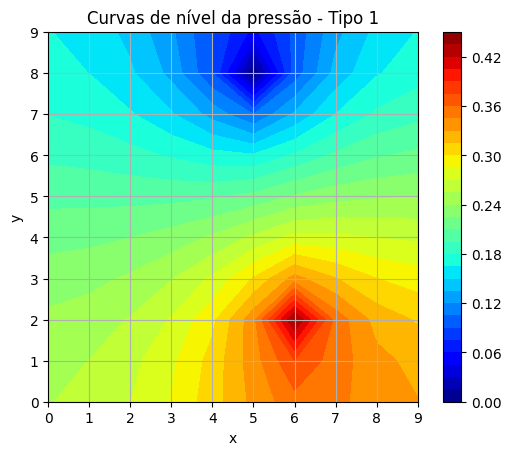

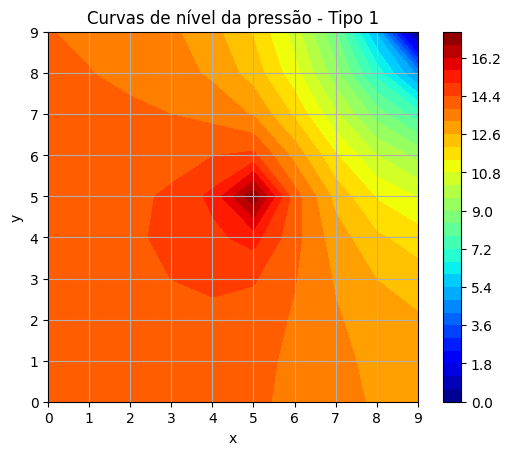

In [220]:
# Dados da rede proposta
col = 10
lin = 10
CH = 3.0
CV = 4.0
# Geração da Rede
nv, nc, conec, C, cond = CriaRedeQuad(col, lin, CH, CV)

def PlotaPress1(lin, col , pressure):
    # Criação de uma meshgrid
    x = np.arange(0, col, 1)
    y = np.arange(0, lin, 1)
    X,Y = np.meshgrid(x,y)
    
    # Armazenamento dos valores das pressões
    Z = np.copy(pressure)
    Z.shape = (lin ,col)
    
    # Plotagem das curvas de nível
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title = 'Curvas de pressão - Tipo 1')
    ax.grid()
    ax.set_xticks(x)
    ax.set_yticks(y)

    contour = plt.contourf(X, Y, Z, 30, cmap='jet')
    colorbar = plt.colorbar(contour) 
    plt.show()

# Valores de teste para a Rede
natm = 85
nB = 26
QB = 1.2
pressure, max_pressure = ResolveRedes1(nv, nc, C, conec, natm, nB, QB)
PlotaPress1(col, lin, pressure)

# Valores de teste para a Rede
natm = 99
nB = 55
QB = 34.5
pressure, max_pressure = ResolveRedes1(nv, nc, C, conec, natm, nB, QB)
PlotaPress1(col, lin, pressure)

Realizamos o mesmo procedimento para uma Rede do Tipo 2.

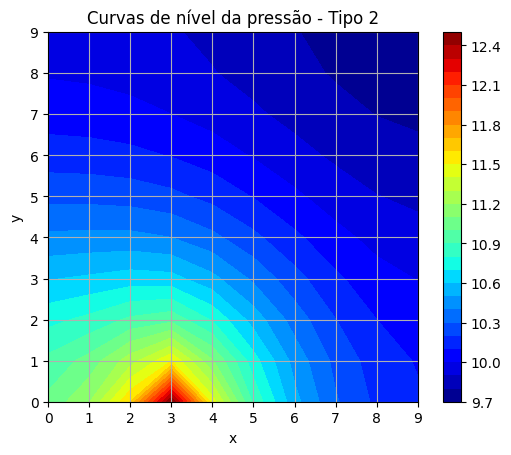

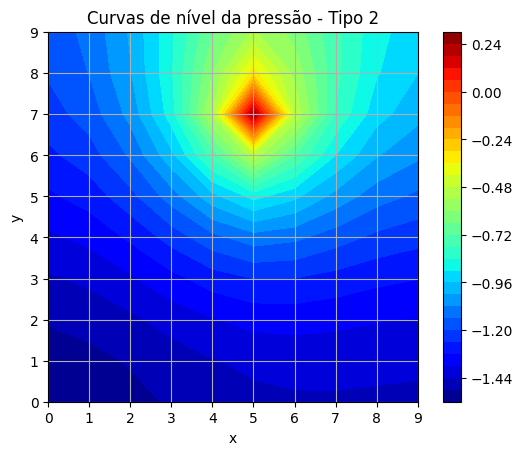

In [221]:
# Dados da rede proposta
col = 10
lin = 10
CH = 3.0
CV = 4.0
# Geração da Rede
nv, nc, conec, C, cond = CriaRedeQuad(col, lin, CH, CV)
# Valores de teste para a Rede
nf = 3
Pf = 12.5
pressure, max_pressure = ResolveRedes2(nv, nc, C, conec, nf, Pf)


def PlotaPress2(lin, col , pressure):
    # Criação de uma meshgrid
    x = np.arange(0, col, 1)
    y = np.arange(0, lin, 1)
    X,Y = np.meshgrid(x,y)
    
    # Armazenamento dos valores das pressões
    Z = np.copy(pressure)
    Z.shape = (lin ,col)
    
    # Plotagem das curvas de nível
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title = 'Curvas de nível da pressão - Tipo 2')
    ax.grid()
    ax.set_xticks(x)
    ax.set_yticks(y)

    contour = plt.contourf(X, Y, Z, 30, cmap='jet')
    colorbar = plt.colorbar(contour) 
    plt.show()

PlotaPress2(col, lin, pressure)

# Valores de teste para a Rede
nf = 75
Pf = 0.25

pressure, max_pressure = ResolveRedes2(nv, nc, C, conec, nf, Pf)
PlotaPress2(col, lin, pressure)

## Exercício B

Definição da função que retorna a matriz Q
$$ Q = K D p $$

In [222]:
def MatrizK(C, nc, nv):
    K = np.zeros(shape = (nc,nc))
    for i in range (nv):
        K[i,i] = C[i]
    return K

def MatrizD(conec, nc, nv):
    D = np.zeros(shape = (nc,nv))
    for i in range (nc):
        D[i][conec[i][0]] = 1.0
        D[i][conec[i][1]] = -1.0
    return D

def RetornaVazao(conec, C, pressure, nc, nv):
    K = MatrizK(C, nc, nv)
    D = MatrizD(conec, nc, nv)
    Q = K @ D @ pressure
    return Q

Agora, vamos alterar a função ResolveRedes1 e ResolveRedes2 para retornar também o valor das vazões. O exemplo concerto será mostrado no exercício C, em conjunto com o valor da pontêcia consumida.

In [223]:
def ResolveRedes1(nv, nc, C, conec, nAtm, nB, QB):
    A = GeraMatriz(nv, nc, C, conec)
    # cópia da matriz A para a nova matriz NovaA
    NovaA = np.copy(A)

    # declaração do vetor das condutancias
    # a vazão no ponto B é igual a Qb
    Soma_cond = np.zeros(nv, dtype = float)
    Soma_cond[nB] = QB

    # a pressão em nAtm é igual a zero
    NovaA[nAtm, :] = 0.0
    NovaA[nAtm, nAtm] = 1.0

    # Cálculo das pressões obtidas
    pressure = np.linalg.solve(NovaA, Soma_cond)
    max_pressure = np.max(pressure)

    # Cálculo da vazão
    Q = RetornaVazao(conec, C, pressure, nc, nv)
    
    return pressure, max_pressure, Q

def ResolveRedes2(nv, nc, C, conec, nf, Pf):
    A = GeraMatriz(nv, nc, C, conec)
    # cópia da matriz A para a nova matriz A
    NovaA = np.copy(A)

    # declaração do vetor das condutancias
    NovaA[nf,:] = 0.0
    NovaA[nf,nf] = 1.0

    # a vazão nos demais canos diminui proporcionalmente ao consumo
    Soma_cond = -0.1 * np.ones(nv, dtype=float)
    Soma_cond[nf] = Pf

    # Cálculo das pressões obtidas
    pressure = np.linalg.solve(NovaA, Soma_cond)
    max_pressure = np.max(pressure)

    # Cálculo da vazão
    Q = RetornaVazao(conec, C, pressure, nc, nv)
    
    return pressure, max_pressure, Q

## Exercício C

Para realizar o cálculo da potência consumida, definimos a função Potência, que realiza a operação

$$ W = p^t (D^t K D) p $$

In [224]:
def Potencia(conec, C, pressure, nc, nv):
    K = MatrizK(C, nc, nv)
    D = MatrizD(conec, nc, nv)
    D_t = np.array(D).T
    p = pressure
    p_t = np.array(pressure)
    
    W = p_t @ (D_t @ K @ D) @ p
    return W

In [225]:
def ResolveRedes1(nv, nc, C, conec, nAtm, nB, QB):
    A = GeraMatriz(nv, nc, C, conec)
    
    # cópia da matriz A para a nova matriz NovaA
    NovaA = np.copy(A)

    # declaração do vetor das condutancias
    # a vazão no ponto B é igual a Qb
    Soma_cond = np.zeros(nv, dtype = float)
    Soma_cond[nB] = QB

    # a pressão em nAtm é igual a zero
    NovaA[nAtm, :] = 0.0
    NovaA[nAtm, nAtm] = 1.0

    # Cálculo das pressões obtidas
    pressure = np.linalg.solve(NovaA, Soma_cond)
    max_pressure = np.max(pressure)

    # Cálculo da vazão
    Q = RetornaVazao(conec, C, pressure, nc, nv)

    # Cálculo da potência consumida
    W = Potencia(conec, C, pressure, nc, nv)
    
    return pressure, max_pressure, Q, W

def ResolveRedes2(nv, nc, C, conec, nf, Pf):
    A = GeraMatriz(nv, nc, C, conec)

    # cópia da matriz A para a nova matriz A
    NovaA = np.copy(A)

    # declaração do vetor das condutancias
    NovaA[nf,:] = 0.0
    NovaA[nf,nf] = 1.0

    # a vazão nos demais canos diminui proporcionalmente ao consumo
    Soma_cond = -0.1 * np.ones(nv, dtype=float)
    Soma_cond[nf] = Pf

    # Cálculo das pressões obtidas
    pressure = np.linalg.solve(NovaA, Soma_cond)
    max_pressure = np.max(pressure)

    # Cálculo da vazão
    Q = RetornaVazao(conec, C, pressure, nc, nv)
    
    # Cálculo da potência consumida
    W = Potencia(conec, C, pressure, nc, nv)
    
    return pressure, max_pressure, Q, W

Por fim, plotamos um exemplo de cada tipo de rede com a adição do retorno dos valores da vazão nos vértices e da potência consumida

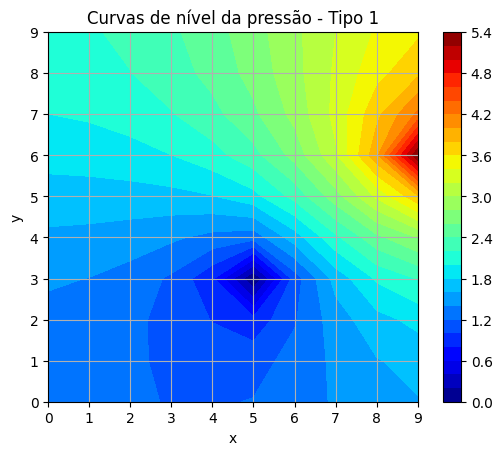

Vazão =  [  0.12902758   0.22482444   0.2400123    0.10571047  -0.24331114
  -0.7444133   -0.96230742  -0.84492723  -0.48430425   0.1733352
   0.33230312   0.43933189   0.3920035   -0.04053708  -1.12202401
  -1.40933982  -1.16925096  -0.6492126    0.2367992    0.50903399
   0.84446102   1.1919128    1.02749875  -2.55852953  -2.55957848
  -1.86684067  -0.98635328   0.25301575   0.60150856   1.23355713
   2.67430988   6.65768691  -8.77500749  -4.63486614  -2.81476316
  -1.46464848   0.14192953   0.3159088    0.54438099   0.76654127
   0.44263695  -3.35526646  -3.61676931  -3.13603457  -2.09565542
  -0.01188967  -0.0423482   -0.13637926  -0.41314121  -1.14041421
  -2.65072616  -3.58832262  -4.20349851  -4.1336974   -0.14095037
  -0.31584185  -0.57349831  -0.9921423   -1.67941342  -2.70980653
  -3.98977003  -6.18426512 -11.59026774  -0.22475625  -0.4789822
  -0.79596734  -1.21297387  -1.76091666  -2.43612635  -3.171842
  -3.88302169  -3.97519858  -0.26926918  -0.55844361  -0.88507452
  -1.

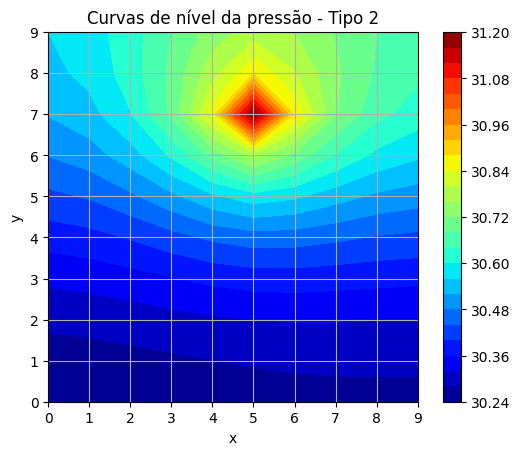

Vazão =  [-1.52563470e-02 -2.74731900e-02 -3.42655689e-02 -3.45534597e-02
 -2.90558251e-02 -2.02517518e-02 -1.14073282e-02 -4.93372621e-03
 -1.47441439e-03 -1.93090188e-02 -3.47058089e-02 -4.29382198e-02
 -4.22674935e-02 -3.34644100e-02 -2.03055521e-02 -8.24623283e-03
 -9.14672627e-04  1.17211552e-03 -2.85779957e-02 -5.14909334e-02
 -6.34817202e-02 -6.08246703e-02 -4.36806942e-02 -1.88933008e-02
  1.21854129e-03  1.00974104e-02  8.16385032e-03 -4.54003832e-02
 -8.28389258e-02 -1.03555670e-01 -9.86977485e-02 -6.40882015e-02
 -1.12469813e-02  2.56606128e-02  3.55260655e-02  2.34626388e-02
 -7.28385584e-02 -1.36482650e-01 -1.77729172e-01 -1.76239661e-01
 -1.08804607e-01  1.76441731e-02  8.61588729e-02  9.01932267e-02
  5.39603767e-02 -1.12536022e-01 -2.19989800e-01 -3.08884051e-01
 -3.41708967e-01 -2.32205978e-01  1.23780767e-01  2.32630928e-01
  1.98549993e-01  1.08094817e-01 -1.59009812e-01 -3.28242988e-01
 -5.14798042e-01 -6.96948811e-01 -6.84252358e-01  5.59432807e-01
  5.69677778e-01

In [226]:
# Dados da rede proposta
col = 10
lin = 10
CH = 8.0
CV = 6.0

# Geração da Rede
nv, nc, conec, C, cond = CriaRedeQuad(col, lin, CH, CV)

# Valores de teste para a Rede
natm = 35
nB = 69
QB = 28.3

pressure, max_pressure, Q1, W1 = ResolveRedes1(nv, nc, C, conec, natm, nB, QB)

PlotaPress1(col, lin, pressure)
print("Vazão = ", Q1)
print("Potencia Consumida = ", W1)

# Valores de teste para a Rede
nf = 75
Pf = 31.2

pressure, max_pressure, Q2, W2 = ResolveRedes2(nv, nc, C, conec, nf, Pf)

PlotaPress2(col, lin, pressure)
print("Vazão = ", Q2)
print("Potencia Consumida = ", W2)

## Exercicio D

Para relaizar a análise de Monte Carlo, primeiro é necessário definir os canos finos, com condutância igual a 2 , e os canos grossos, com condutância igual a 20. 

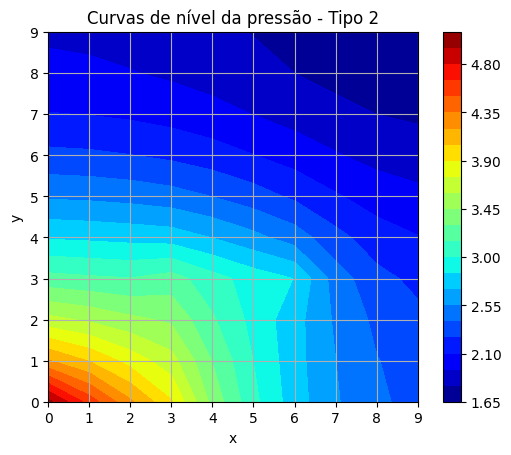

In [227]:
# Dados da rede proposta
col = 10
lin = 10
CH = 2.0
CV = 2.0
nf = 0
Pf = 5

# Geração da Rede
nv, nc, conec, C, cond = CriaRedeQuad(col, lin, CH, CV)

# Adição de canos grossos 
grossos = [0, 1, 2, 30, 31, 32, 93, 103, 113]
C[grossos] = 20

# evaluate the pressure on each vertex
pressure, max_pressure, Q2, W2 = ResolveRedes2(nv, nc, C, conec, nf, Pf)

PlotaPress2(col, lin, pressure)


Em seguida, definimos a função FalhaAleatoria, que randomicamente altera as condutâncias dos canos por meio da geração de núemros aleátórios entre 0 e 1. Caso o cano enteja entupido, sua condutância

In [230]:
def FalhaAleatoria(C, a, C_ent):
    Cnova = np.copy(C)
    np = np.shape(C)[0]

    for i in range (nc):
        x = np.random.rand() #gera numeros aleatorios entre 0 e 1
        if(x < a and C[i] == 2): # se o numero gerado for menor que a p_clog e o cano eh fino
            Cnova[i] = C_ent
    
    return Cnova

def MonteCarlo(nc, nv, conec, C, rep, C_ent, a):
    soma_falhas = 0
    for i in range (rep):
        C = FalhaAleatoria(C, a, C_ent)

        pressure = ResolveRedes2(nv, nc, C, conec, nf, Pf)

        if (np.min(pressure) < 1.15):
            soma_falhas += 1
    prob_falha = 100* soma_falhas / rep
    return prob_falha

In [233]:

rep = 2500
probabilidades = []
prob_ent = []


for a in np.arange (0.02, 0.251, 0.005):
    prob_falha = MonteCarlo(nc, nv, C, rep, C_ent, a)
    probabilidades.append(prob_falha)
    prob_ent.append(a)

fig, ax = plt.subplots()
fig.set_dpi(100)

ax.plot(prob_ent, probabilidades, "-")
ax.set_xlabel(r"Probabilidade de Entupimento do Cano ($p_{clog}$)", labelpad=7)
ax.set_ylabel(r"Probabilidade de Falha $(\%)$", labelpad=7)
plt.title("Probabilidade de Falha em Função da Probabilidade de Entupimento dos Canos", pad=20)
plt.grid()

plt.show()
    

TypeError: MonteCarlo() missing 1 required positional argument: 'repeticoes'